In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sps
import scipy.integrate as spint
import scipy.interpolate as spinterp
import pandas as pd
import scipy.optimize as spopt

### Exercise 1:

Reading the 'sdss_quasars.txt' data: 

In [2]:
names_q=['ID','RA','DEC','REDSHIFT','FLAG','LOGLBOL','LOGLBOL_ERR','R_6CM_2500A','LOGL5100','LOGL5100_ERR',
'LOGL3000','LOGL3000_ERR','LOGL1350','LOGL1350_ERR','LOGL_BROAD_HA', 'LOGL_BROAD_HA_ERR','LOGL_NARROW_HA',
'LOGL_NARROW_HA_ERR','LOGL_BROAD_HB','LOGL_BROAD_HB_ERR','LOGL_NARROW_HB','LOGL_NARROW_HB_ERR','LOGL_OIII_5007',
'LOGL_OIII_5007_ERR','LOGL_MGII','LOGL_MGII_ERR','LOGL_CIV','LOGL_CIV_ERR','LOGBH','LOGBH_ERR']

#No Nan values or '-' in the data. 
quasars = pd.read_csv('sdss_quasars.txt', delim_whitespace=True,skiprows=1, skipfooter=2, engine='python',
names=names_q,index_col=False)

#Test of data reading:
print(quasars.dtypes,quasars.shape)

ID                      int64
RA                    float64
DEC                   float64
REDSHIFT              float64
FLAG                    int64
LOGLBOL               float64
LOGLBOL_ERR           float64
R_6CM_2500A           float64
LOGL5100              float64
LOGL5100_ERR          float64
LOGL3000              float64
LOGL3000_ERR          float64
LOGL1350              float64
LOGL1350_ERR          float64
LOGL_BROAD_HA         float64
LOGL_BROAD_HA_ERR     float64
LOGL_NARROW_HA        float64
LOGL_NARROW_HA_ERR    float64
LOGL_BROAD_HB         float64
LOGL_BROAD_HB_ERR     float64
LOGL_NARROW_HB        float64
LOGL_NARROW_HB_ERR    float64
LOGL_OIII_5007        float64
LOGL_OIII_5007_ERR    float64
LOGL_MGII             float64
LOGL_MGII_ERR         float64
LOGL_CIV              float64
LOGL_CIV_ERR          float64
LOGBH                 float64
LOGBH_ERR             float64
dtype: object (9998, 30)


1)The values of sdss_quasars.txt that are needed for this exercise are the luminocity values of LOGL3000, LOGL_MGII,the logarithmic mass of the black holes LOGBH and the radio loudness R_6CM_2500A.Those data has to be cleaned by the conditions of all values being higher than zero,the error of $\log_{10}(luminocity)$ being smaller than 0.1 and the error of $\log_{10}(mass_{BH})$ being smaller than 0.2:

In [3]:
#Condition of the values being higher than 0:
qclean=quasars[quasars.LOGBH>0]
qclean=qclean[qclean.LOGL3000>0]
qclean=qclean[qclean.LOGL_MGII>0]
qclean=qclean[qclean.R_6CM_2500A>0]

#Conditions of the error of the luminocities and black hole's mass:
qclean=qclean[qclean.LOGBH_ERR<0.2]
qclean=qclean[qclean.LOGL3000_ERR<0.1]
qclean=qclean[qclean.LOGL_MGII_ERR<0.1]

print("rows remained ",len(qclean)," from the initial number of rows ",len(quasars))

rows remained  474  from the initial number of rows  9998


2)Plot of labelled scatter-plot matrix showing of the variables:$\log_{10}(L_{3000}),\log_{10}(L_{MGII}),\log_{10}$(radio loudness),$\log_{10}(M_{BH})$.

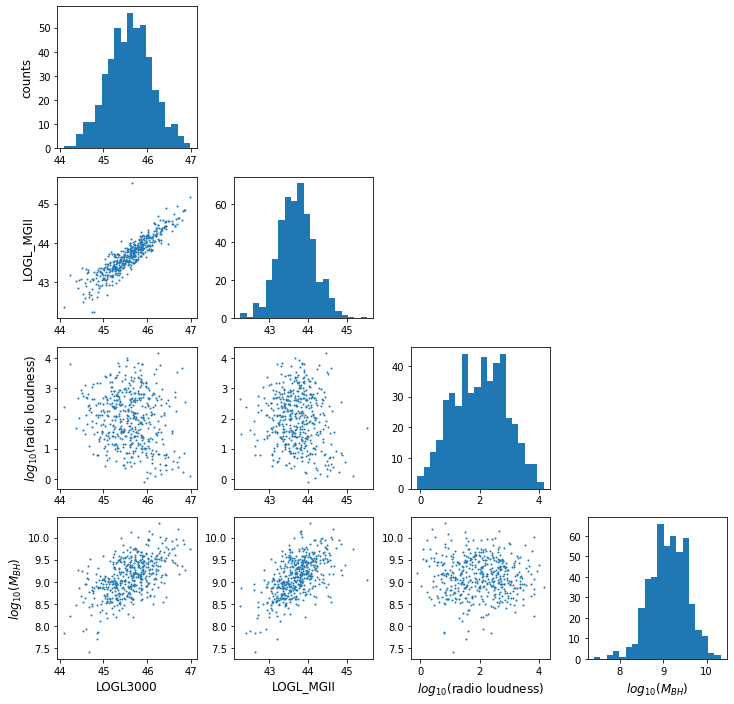

In [4]:
#Selecting the appropriate data categories:
#Stacking only the wanted data categories in a numpy array: 
q_array = np.column_stack((qclean.LOGL3000,qclean.LOGL_MGII,np.log10(qclean.R_6CM_2500A),qclean.LOGBH))
ndims=4
labels = ['LOGL3000', 'LOGL_MGII','$log_{10}$(radio loudness)','$log_{10}(M_{BH})$']
fig, axes = plt.subplots(ndims,ndims,figsize=(12,12))
fig.subplots_adjust(wspace=0.27,hspace=0.2)
for i in range(ndims):
    for j in range(ndims):
        if i == j:
            axes[i,j].hist(q_array[:,i], bins=20)
        elif i > j:
            axes[i,j].scatter(q_array[:,j],q_array[:,i],s=1)
        else:
            axes[i,j].axis('off')
        if j == 0:
            if i == j:
                axes[i,j].set_ylabel('counts',fontsize=12)
            else:
                axes[i,j].set_ylabel(labels[i],fontsize=12)
        if i == 3:
            axes[i,j].set_xlabel(labels[j],fontsize=12)
plt.show()

3)Scatter plot of:$\log_{10}(L_{3000}),\log_{10}$(radio loudness),$\log_{10}(M_{BH})$.

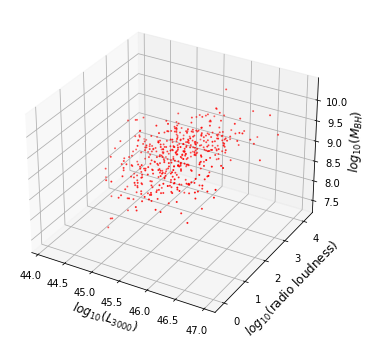

In [5]:
#%matplotlib notebook
#%matplotlib widget
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(qclean.LOGL3000, np.log10(qclean.R_6CM_2500A), qclean.LOGBH, c="red", s=1)
ax.set_xlabel('$log_{10}(L_{3000})$', fontsize=12)
ax.set_ylabel('$log_{10}$(radio loudness)', fontsize=12)
ax.set_zlabel('$log_{10}(M_{BH})$', fontsize=12)
plt.show()

### Exercise 2: 

I am using the cleaned data from the previous exercise for this part since the same values of the total data are needed.I create two sub samples of the total data based on the radio loudness values,with one sample being the data with radio loudness values below the median radio loudness and one with values above the radio loudness median.In this exercise the main goal is to determine whether the sample means of a quantity of the sub-samples are drawn from different populations for each sub-sample or not and so the t-distribution is used.

In [6]:
#Creating the two sub-samples:
quasars_ab=qclean[qclean.R_6CM_2500A>np.median(qclean.R_6CM_2500A)]
quasars_bel=qclean[qclean.R_6CM_2500A<np.median(qclean.R_6CM_2500A)]

#Black hole mass mean for each sub-sample and the mean of the total sample:
bh_mean_ab=np.mean(quasars_ab.LOGBH)
bh_mean_bel=np.mean(quasars_bel.LOGBH)
bh_mean_tot=np.mean(qclean.LOGBH)

#Test of the sub samples sizes,due to the odd number of data they are expected to have equal sizes:
print(" Sample above radioloudness median size:",len(quasars_ab),
      "\n sample below radioloudness median size:",len(quasars_bel),"\n")

#Values of the mean log_10(M_BH) values of the sub-samples and the total sample:
print(" Mean log_10(M_BH) mass of sample above radioloudness median:",bh_mean_ab,
      "\n Mean log_10(M_BH) mass of sample below radioloudness median:",bh_mean_bel,
      "\n Mean log_10(M_BH) mass of total sample:",bh_mean_tot)

 Sample above radioloudness median size: 237 
 sample below radioloudness median size: 237 

 Mean log_10(M_BH) mass of sample above radioloudness median: 9.111269521654826 
 Mean log_10(M_BH) mass of sample below radioloudness median: 9.120823028510655 
 Mean log_10(M_BH) mass of total sample: 9.116046275082738


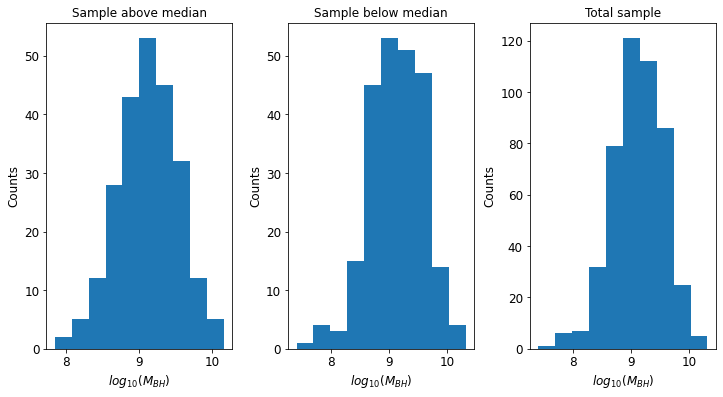

 Mean log_10(M_BH) test:
 Sample above radioloudness median vs sample below radioloudness median
 Assuming equal population variances:
 T =  -0.23877977199232844 and p-value = 0.8113799934746333
 Allowing different population variances:
 T =  -0.23877977199232844 and p-value = 0.8113822225451286


In [7]:
fig, (ax1, ax2,ax3) = plt.subplots(1,3, figsize=(12,6))
fig.subplots_adjust(wspace=0.3)

ax1.hist(quasars_ab.LOGBH)
ax2.hist(quasars_bel.LOGBH)
ax3.hist(qclean.LOGBH)

for ax in (ax1,ax2,ax3):
    ax.tick_params(labelsize=12)
    ax.set_xlabel('$log_{10}(M_{BH})$', fontsize=12)
    ax.set_ylabel("Counts", fontsize=12)
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    
ax1.set_title("Sample above median")
ax2.set_title("Sample below median")
ax3.set_title("Total sample")
plt.show()

print(" Mean log_10(M_BH) test:\n Sample above radioloudness median vs sample below radioloudness median")
#two-sample t-test
print(" Assuming equal population variances:")
tstat, pval = sps.ttest_ind(quasars_ab.LOGBH,quasars_bel.LOGBH,equal_var=True)
print(" T = ",tstat,"and p-value =",pval)
print(" Allowing different population variances:")
tstat, pval = sps.ttest_ind(quasars_ab.LOGBH,quasars_bel.LOGBH,equal_var=False)
print(" T = ",tstat,"and p-value =",pval)

From the plots of the $log_{10}(M_{BH})$ histograms we can see that the values of all samples follows distributions very close to the normal distribution,while the samples' sizes are big enough for the central limit theorem for the means of those samples to be a good assumption.So we can use the t-test,with both p values as shown for assuming equal population variances or different population variances being very high.So the mean black hole mass for each sub-sample is drawn from the same population.

The values of sdss_quasars.txt that are needed for this exercise are the same as before with the 
addition of LOGL1350.Those data has also to be cleaned by the conditions of values being higher than zero and 
its error being smaller than 0.1:

In [8]:
#data cleaning of LOGL1350:
qclean_2=qclean[qclean.LOGL1350>0]
qclean_2=qclean_2[qclean_2.LOGL1350_ERR<0.1]
#The new sub-samples after the additional cleaning:
quasars_ab_2=qclean_2[qclean_2.R_6CM_2500A>np.median(qclean_2.R_6CM_2500A)]
quasars_bel_2=qclean_2[qclean_2.R_6CM_2500A<np.median(qclean_2.R_6CM_2500A)]

quasars_ab_2['colour']=quasars_ab_2.LOGL1350-quasars_ab_2.LOGL3000
quasars_bel_2['colour']=quasars_bel_2.LOGL1350-quasars_bel_2.LOGL3000
qclean_2['colour']=qclean_2.LOGL1350-qclean_2.LOGL3000

colour_mean_ab=np.mean(quasars_ab_2.colour)
colour_mean_bel=np.mean(quasars_bel_2.colour)
colour_mean_tot=np.mean(qclean_2.colour)

#Test of the sub samples sizes after the additional cleaning:
print(" Sample above radioloudness median size:",len(quasars_ab_2),
      "\n sample below radioloudness median size:",len(quasars_bel_2),"\n")

#Values of the mean colour values of the sub-samples and the total sample:
print(" Mean colour of sample above radioloudness median:",colour_mean_ab,
      "\n Mean colour of sample below radioloudness median:",colour_mean_bel,
      "\n Mean colour of total sample:",colour_mean_tot)


 Sample above radioloudness median size: 66 
 sample below radioloudness median size: 66 

 Mean colour of sample above radioloudness median: 0.13799734248984857 
 Mean colour of sample below radioloudness median: 0.013125938400909852 
 Mean colour of total sample: 0.07366999819135381


<ipython-input-8-18ae134ce5c1>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quasars_ab_2['colour']=quasars_ab_2.LOGL1350-quasars_ab_2.LOGL3000
<ipython-input-8-18ae134ce5c1>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quasars_bel_2['colour']=quasars_bel_2.LOGL1350-quasars_bel_2.LOGL3000


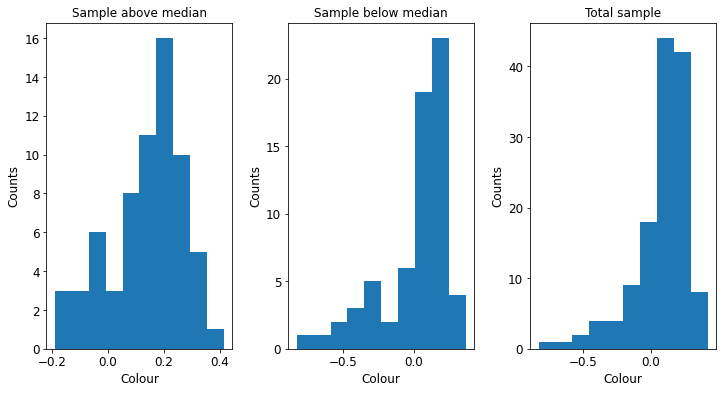

mean colour above: 0.13799734248984857
mean colour below: 0.013125938400909852
Assuming equal population variances:
T =  3.6685346692146066 and p-value = 0.0003546035664304562

Allowing different population variances:
T =  3.6685346692146066 and p-value = 0.0003871930987477038


In [9]:
fig, (ax1, ax2,ax3) = plt.subplots(1,3, figsize=(12,6))
fig.subplots_adjust(wspace=0.3)

ax1.hist(quasars_ab_2.colour)
ax2.hist(quasars_bel_2.colour)
ax3.hist(qclean_2.colour)

for ax in (ax1,ax2,ax3):
    ax.tick_params(labelsize=12)
    ax.set_xlabel("Colour", fontsize=12)
    ax.set_ylabel("Counts", fontsize=12)
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)

ax1.set_title("Sample above median")
ax2.set_title("Sample below median")
ax3.set_title("Total sample")
plt.show()

print("mean colour above:",np.mean(quasars_ab_2.colour))
print("mean colour below:",np.mean(quasars_bel_2.colour))

print("Assuming equal population variances:")
tstat, pval = sps.ttest_ind(quasars_ab_2.colour,quasars_bel_2.colour,equal_var=True)
print("T = ",tstat,"and p-value =",pval)
print("\nAllowing different population variances:")
tstat, pval = sps.ttest_ind(quasars_ab_2.colour,quasars_bel_2.colour,equal_var=False)
print("T = ",tstat,"and p-value =",pval)

From the plots of the "colour" histograms we can see that the values of all samples follows distributions close to the log normal distribution,while the samples' sizes are big enough for the central limit theorem (showed in the assignments 1) for the means of those samples to be a good assumption.We use the t-test,with both p values as shown for assuming equal population variances or different population variances being very low.The small sized samples have better accuracy for the t-test for low p values and so we can "trust" their values since the t-distribution's assumptions are true.Based on those p values the hypothesis that the sample means of colour are drawn from the same population for each sub-sample is rejected at 3 $\sigma$ significance level.

### Exercise 3: 

In this part of this exercise the cleaned data from the exercise 1 (episode 6) is used in order to determine if there is a correlation between the values of LOGL3000,LOGL_MGII,R_6CM_2500A,LOGBH through Pearson's and Spearman's coefficients.Also the repsected scatter plots of these values are shown since the above coefficients cannot determine "alone" if there is correlation or not and additional visual information is needed.Also,based on the histograms at exercise 1 (episode 6) it can be observed that all those variables follows distributions very close to normal distribution and so although the sample size is small ($n_{sample}<500$) the central limit theorem and the assumptions of Pearson's and Spearman's coefficients are true.

Correlation test:
Correlation: LOGL3000 vs LOGL_MGII
Pearson's r and p-value: 0.8982712179195192 1.1492381268683022e-170
Spearman's rho and p-value: 0.915642651199412 6.223973591888784e-189 

Correlation: LOGL3000 vs R_6CM_2500A
Pearson's r and p-value: 0.02328883019685202 0.6130226259410523
Spearman's rho and p-value: -0.1445253270194782 0.0016060283730266196 

Correlation: LOGL3000 vs LOGBH
Pearson's r and p-value: 0.5510235664411556 5.397474302184091e-39
Spearman's rho and p-value: 0.5327473016579505 4.1803910915512116e-36 

Correlation: LOGL_MGII vs R_6CM_2500A
Pearson's r and p-value: 0.05390763707059046 0.24143586070836726
Spearman's rho and p-value: -0.07856822724244446 0.08751078103072146 

Correlation: LOGL_MGII vs LOGBH
Pearson's r and p-value: 0.5691002748890208 4.94322160827059e-42
Spearman's rho and p-value: 0.562696947630403 6.189067633262397e-41 

Correlation: R_6CM_2500A vs LOGBH
Pearson's r and p-value: -0.017659494833515095 0.70135709029498
Spearman's rho and p-value:

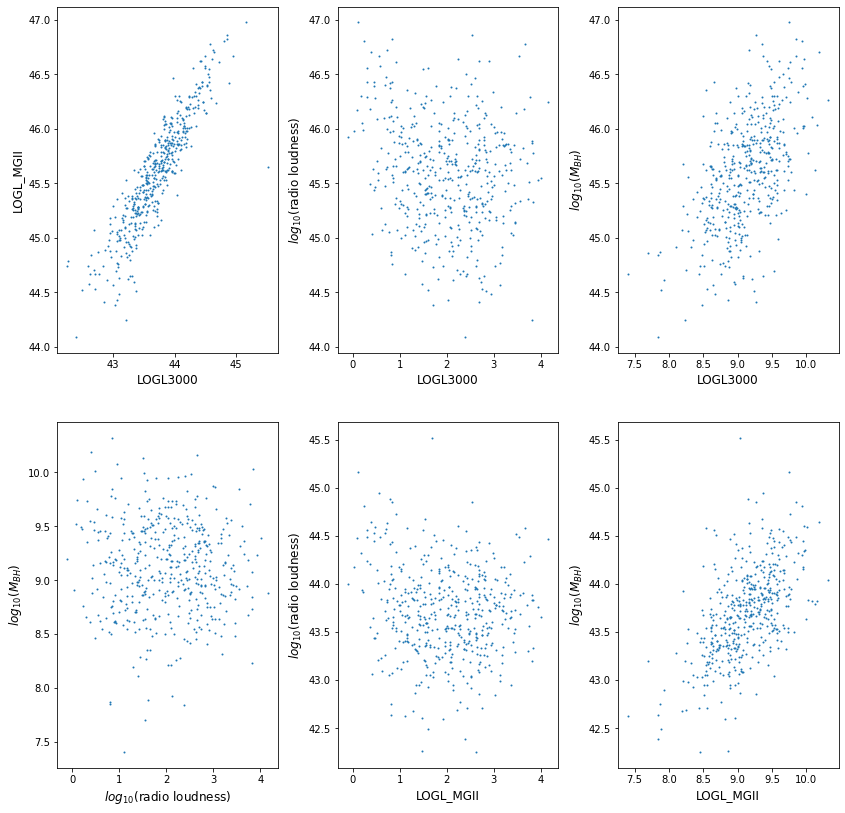

In [10]:
#Calculating Pearson's and Spearman's coefficients between the wanted variables:
q_array = np.column_stack((qclean.LOGL3000,qclean.LOGL_MGII,np.log10(qclean.R_6CM_2500A),qclean.LOGBH))
ndims=4
labels = ['LOGL3000', 'LOGL_MGII','R_6CM_2500A','LOGBH']

print("Correlation test:")
for i in range(0,len(labels)):
    for j in range(i,len(labels)):
        if i!=j:
            print("Correlation:",labels[i],"vs",labels[j])
            (rcor, rpval) = sps.pearsonr(qclean[labels[i]],qclean[labels[j]])
            (rhocor, rhopval) = sps.spearmanr(qclean[labels[i]],qclean[labels[j]])

            print("Pearson's r and p-value:",rcor, rpval)
            print("Spearman's rho and p-value:",rhocor, rhopval ,"\n")
            
#Creating all scatter plots between the wanted variables: 
q_array = np.column_stack((qclean.LOGL3000,qclean.LOGL_MGII,np.log10(qclean.R_6CM_2500A),qclean.LOGBH))
ndims=4
labels = ['LOGL3000', 'LOGL_MGII','$log_{10}$(radio loudness)','$log_{10}(M_{BH})$']
fig, axes = plt.subplots(2,3,figsize=(14,14))
fig.subplots_adjust(wspace=0.27,hspace=0.2)
for i in range(2):
    for j in range(3):
        if i==1 and j==0:
            axes[1,0].scatter(q_array[:,2],q_array[:,3],s=1)
            axes[1,0].set_ylabel(labels[3],fontsize=12)
            axes[1,0].set_xlabel(labels[2],fontsize=12)
        else:
            axes[i,j].scatter(q_array[:,j+1],q_array[:,i],s=1)
            axes[i,j].set_ylabel(labels[j+1],fontsize=12)
            axes[i,j].set_xlabel(labels[i],fontsize=12)

plt.show()

All the above variables follow normal distributions as it can be seen at the exercise 1 (episode 6) and so the assumptions of the corellation coefficients are true.By the p values and the scatter plots an easilly observed result is that the radio loudness variable is not correlated with the other variables.The correlation between the $log_{10}(M_{BH})$ and both the $log_{10}L_{3000}$ and $log_{10}L_{MGII}$ is also observed by the very small p values and the coefficients values,which imply a simillar correlation for both cases. From the coefficients values it can be seen that (also visually observed in the scatter plots) that the $log_{10}(M_{BH})$ in increasing monotonically with increasing both $log_{10}L_{3000}$ and $log_{10}L_{MGII}$.Finally,the higher correlation (smaller p values by far in the above correlation tests) exist between $log_{10}L_{3000}$ and $log_{10}L_{MGII}$ with a monotonically non-decreasing relation as it is observed by the coefficients values and the respected plot.

Below it is shown a function for linear regression of LOGL3000,LOGL_MGII values with plotting the given points and the fitted line with additional the residual of each point.In the end important parameters of the linear regression are being printed.

In [11]:
def lin_lum(quasar,title=None):
    fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8,6),sharex=True,gridspec_kw={'height_ratios':[2,1]})
    fig.subplots_adjust(hspace=0)
    lin_param=sps.linregress(quasar.LOGL3000,quasar.LOGL_MGII)
    ax1.plot(quasar.LOGL3000, quasar.LOGL_MGII, 'o', label='original data')
    ax1.plot(quasar.LOGL3000, lin_param[1] + lin_param[0]*quasar.LOGL3000, 'r', label='fitted line')
    ax1.set_ylabel("$log_{10}L_{3000}$", fontsize=14)
    ax1.tick_params(axis="x",direction="in",labelsize=12)
    ax2.plot(quasar.LOGL3000, quasar.LOGL_MGII-(lin_param[1] + lin_param[0]*quasar.LOGL3000), "o")
    ax2.set_xlabel("$log_{10}L_{MGII}$",fontsize=14)
    ax2.set_ylabel(" ", fontsize=14)
    ax2.axhline(0.0,ls=':') 
    ax2.tick_params(labelsize=12)
    ax1.legend(fontsize=10)
    if title!=None:
        ax1.set_title(title)
    plt.show()
    if title==None:
        print(" Parameters of linear regreassion:")
    else:
        print(" "+title+":Parameters of linear regreassion:")
    print(" Gradient:",lin_param[0],"Offset:",lin_param[1])
    print("________________________________________________________________  \n")

Below we use linear regression for the cleaned data of exercise 1 (episode 6) and the two sub samples as defined at the begining of exercise 2 (episode 7) without the cleaned LOGL1350 data.

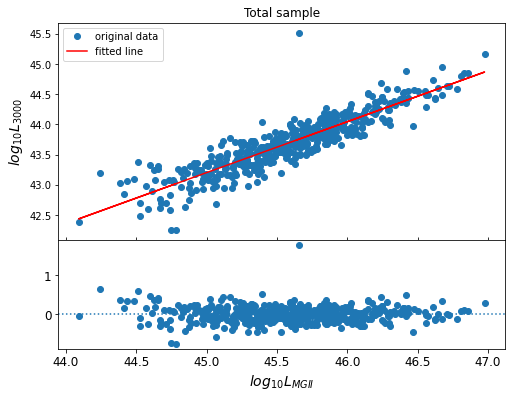

 Total sample:Parameters of linear regreassion:
 Gradient: 0.8418626932084016 Offset: 5.3194031462473035
________________________________________________________________  



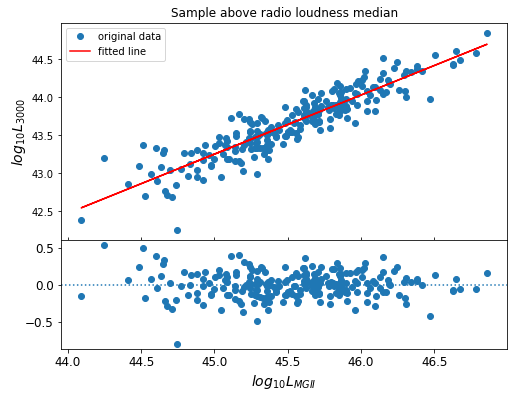

 Sample above radio loudness median:Parameters of linear regreassion:
 Gradient: 0.7765572019542037 Offset: 8.305230420140802
________________________________________________________________  



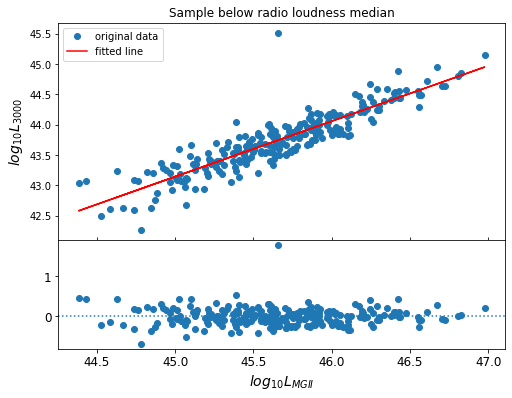

 Sample below radio loudness median:Parameters of linear regreassion:
 Gradient: 0.9142666422977972 Offset: 2.0017068047286344
________________________________________________________________  



In [12]:
lin_lum(qclean,title="Total sample")
lin_lum(quasars_ab,title="Sample above radio loudness median")
lin_lum(quasars_bel,title="Sample below radio loudness median")


In the above parameters of each sample we can see that the gradient and offset are very different for each case.But a clear statistical reasoning for which of the relations is better one or how to define if these relations are based on the same relation with their differences being results of the effects of random variations.This will be done in the next exercise.

### Exercise 4: 
In this exercise bootstrapping process is applied to the previous linear regression problem on the two sub-samples of the exercise 2 (episode 7):

In [13]:
def bootstrap(quasars,sample=None):
    LOGL_MGII=np.array(quasars.LOGL_MGII)
    LOGL3000=np.array(quasars.LOGL3000)
    indices = np.arange(len(LOGL3000))
    nsims=1000
    a_arr = np.zeros(nsims)
    b_arr = np.zeros(nsims)
    rng = np.random.default_rng()
    for i in range(nsims):
        new_indices = rng.choice(indices ,size=len(LOGL_MGII), replace=True)
        r2 =sps.linregress(LOGL3000[new_indices],LOGL_MGII[new_indices])
        a_arr[i] = r2[0]
        b_arr[i] = r2[1]
    
    plt.plot(a_arr, b_arr, "o")
    plt.xlabel("a", fontsize=14)
    plt.ylabel("b", fontsize=14)
    plt.tick_params(axis='x', labelsize=12)
    plt.tick_params(axis='y', labelsize=12)
    if sample!=None:
        print(sample,":")
    print("The mean and standard deviations of the bootstrapped samples of gradient are:",
          round(np.mean(a_arr),3),"and",round(np.std(a_arr,ddof=1),3),"respectively")
    print("The mean and standard deviations of the bootstrapped samples of offset  are:",
          round(np.mean(b_arr),3),"and",round(np.std(b_arr,ddof=1),3),"respectively \n")
    
    print("Correlation of offset and gradient:")
    (rcor, rpval) = sps.pearsonr(a_arr,b_arr)
    (rhocor, rhopval) = sps.spearmanr(a_arr,b_arr)
    print("Pearson's r and p-value:",rcor, rpval)
    print("Spearman's rho and p-value:",rhocor, rhopval ,"\n")
    print("__________________________________________________________________________________________________ \n")
 

Sample above radioloudness median :
The mean and standard deviations of the bootstrapped samples of gradient are: 0.778 and 0.028 respectively
The mean and standard deviations of the bootstrapped samples of offset  are: 8.248 and 1.272 respectively 

Correlation of offset and gradient:
Pearson's r and p-value: -0.9999638394296282 0.0
Spearman's rho and p-value: -0.9999393279393282 0.0 

__________________________________________________________________________________________________ 

Sample below radioloudness median :
The mean and standard deviations of the bootstrapped samples of gradient are: 0.916 and 0.03 respectively
The mean and standard deviations of the bootstrapped samples of offset  are: 1.912 and 1.374 respectively 

Correlation of offset and gradient:
Pearson's r and p-value: -0.9999451494125176 0.0
Spearman's rho and p-value: -0.9999218199218199 0.0 

__________________________________________________________________________________________________ 



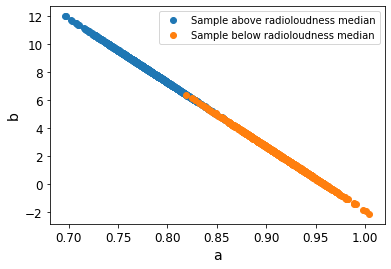

In [14]:
bootstrap(quasars_ab,"Sample above radioloudness median")
bootstrap(quasars_bel,"Sample below radioloudness median")
plt.legend(["Sample above radioloudness median","Sample below radioloudness median"])
plt.show()

